# Load DataFrames

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt

path_root = "/Spring2020_VisualAnalytics/output/"

df_academies = pd.read_csv(os.path.join(path_root, "academies.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_aristo_title = pd.read_csv(os.path.join(path_root, "aristo_title.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_egonetworkscombined = pd.read_csv(os.path.join(path_root, "egonetworkscombined.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_knowledge_network = pd.read_csv(os.path.join(path_root, "knowledge_network.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
# df_main = pd.read_csv(os.path.join(path_root, "main.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_military_rank = pd.read_csv(os.path.join(path_root, "military_rank.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_nationality = pd.read_csv(os.path.join(path_root, "nationality.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_occupation = pd.read_csv(os.path.join(path_root, "occupation.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_political_rank = pd.read_csv(os.path.join(path_root, "political_rank.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_professional_network = pd.read_csv(os.path.join(path_root, "professional_network.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_salons = pd.read_csv(os.path.join(path_root, "salons.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_social_network = pd.read_csv(os.path.join(path_root, "social_network.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")
df_source = pd.read_csv(os.path.join(path_root, "source.tsv"), index_col="SP ID", sep='\t', encoding = "unicode_escape")

df_raw = pd.read_csv("salons_project_raw_data.tsv", index_col="SP ID", sep='\t', encoding = "ISO-8859-1")

## Create edge list

In [2]:
from itertools import combinations

def create_pandas_edgelist(input_df, column):

    df = pd.DataFrame(columns=["Source","Target"])
    
    for index in range(0, input_df.shape[0]):
        df_temp = pd.DataFrame(columns=["Source","Target"])
        
        comma_sep_value = [i.strip() for i in input_df[column].values[index].split(",")]
        if len(comma_sep_value) == 1:
            df_temp.loc[len(df_temp)] = comma_sep_value * 2
        else:
            comma_sep_value = list(combinations(comma_sep_value, 2))
            df_temp = pd.DataFrame(comma_sep_value, columns=["Source","Target"])
        df = df.append(df_temp, ignore_index=True)
    
    df = df.groupby(['Source','Target']).size().reset_index()
    df = df.rename({0: "Pair Counts"}, axis=1)
    
    return df

df_edgelist = create_pandas_edgelist(input_df=df_raw, column="EgoNetworksCombined")
df_edgelist[:10]

,Source,Target,Pair Counts
0,ASmith,Boufflers,2
1,ASmith,Deffand,1
2,ASmith,Encyclopedistes,1
3,ASmith,Geoffrin,2
4,ASmith,Graffigny,1
5,ASmith,Holbach,3
6,ASmith,Lespinasse,4
7,ASmith,Stormont,1
8,Arnould,Arnould,2
9,Arnould,Boufflers,1


## Create edge list

In [3]:
from itertools import combinations

def create_pandas_attribute(input_df, comma_sep_column, attribute_column):
    
    input_df = input_df.reset_index()
    df = pd.DataFrame(columns=["SP ID", comma_sep_column, attribute_column])
    
    for index in range(0, input_df.shape[0]):
        comma_sep_value = [i.strip() for i in input_df[comma_sep_column].values[index].split(",")]
        df_temp = pd.DataFrame(comma_sep_value, columns=[comma_sep_column])
        
        df = df.append(df_temp, ignore_index=True)
        df[attribute_column] = df[attribute_column].fillna(value=input_df[attribute_column].values[index])
        df["SP ID"] = df["SP ID"].fillna(value=int(input_df["SP ID"].values[index]))

    df["SP ID"] = df["SP ID"].astype(int)
    
    df = df[[comma_sep_column, attribute_column]].groupby([comma_sep_column, attribute_column]).size().reset_index()
    df = df.rename({0: "Attribute Counts"}, axis=1)
    
    df = pd.pivot_table(
        df[df[attribute_column].isin(["Male","Female"])],
        values="Attribute Counts",
        index=comma_sep_column,
        columns=attribute_column
    )
    
    df = df.reset_index()
    df = df.fillna(0)
    df['Majority Attribute'] = df.iloc[:,1:].idxmax(axis=1)
    df = df[[comma_sep_column,"Majority Attribute"]]
    
    return df

df_attribute = create_pandas_attribute(input_df=df_raw, comma_sep_column="EgoNetworksCombined", attribute_column="GenderGroup")
df_attribute[:10]

c:\programdata\anaconda3\envs\viz-analytics\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


GenderGroup,EgoNetworksCombined,Majority Attribute
0,,Female
1,ASmith,Male
2,Arnould,Male
3,Beauvau,Female
4,Bentham,Male
5,Bolingbroke,Male
6,Boufflers,Male
7,Boufflers-Luxembourg,Female
8,Brionne,Female
9,Chatelet,Male


## Ego network / gender network

In [4]:
ego_network_counts_df = df_egonetworkscombined.groupby(["EgoNetworksCombined"])["EgoNetworksCombined"].count()
ego_network_counts_df = pd.DataFrame(ego_network_counts_df)
ego_network_counts_df = ego_network_counts_df.rename(columns={"EgoNetworksCombined" : "Ego Network Count"})

# merge counts with edge list
df_edgelist = df_edgelist.merge(ego_network_counts_df, how="left", left_on="Source", right_on="EgoNetworksCombined")
df_edgelist[:10]

,Source,Target,Pair Counts,Ego Network Count
0,ASmith,Boufflers,2,5
1,ASmith,Deffand,1,5
2,ASmith,Encyclopedistes,1,5
3,ASmith,Geoffrin,2,5
4,ASmith,Graffigny,1,5
5,ASmith,Holbach,3,5
6,ASmith,Lespinasse,4,5
7,ASmith,Stormont,1,5
8,Arnould,Arnould,2,13
9,Arnould,Boufflers,1,13


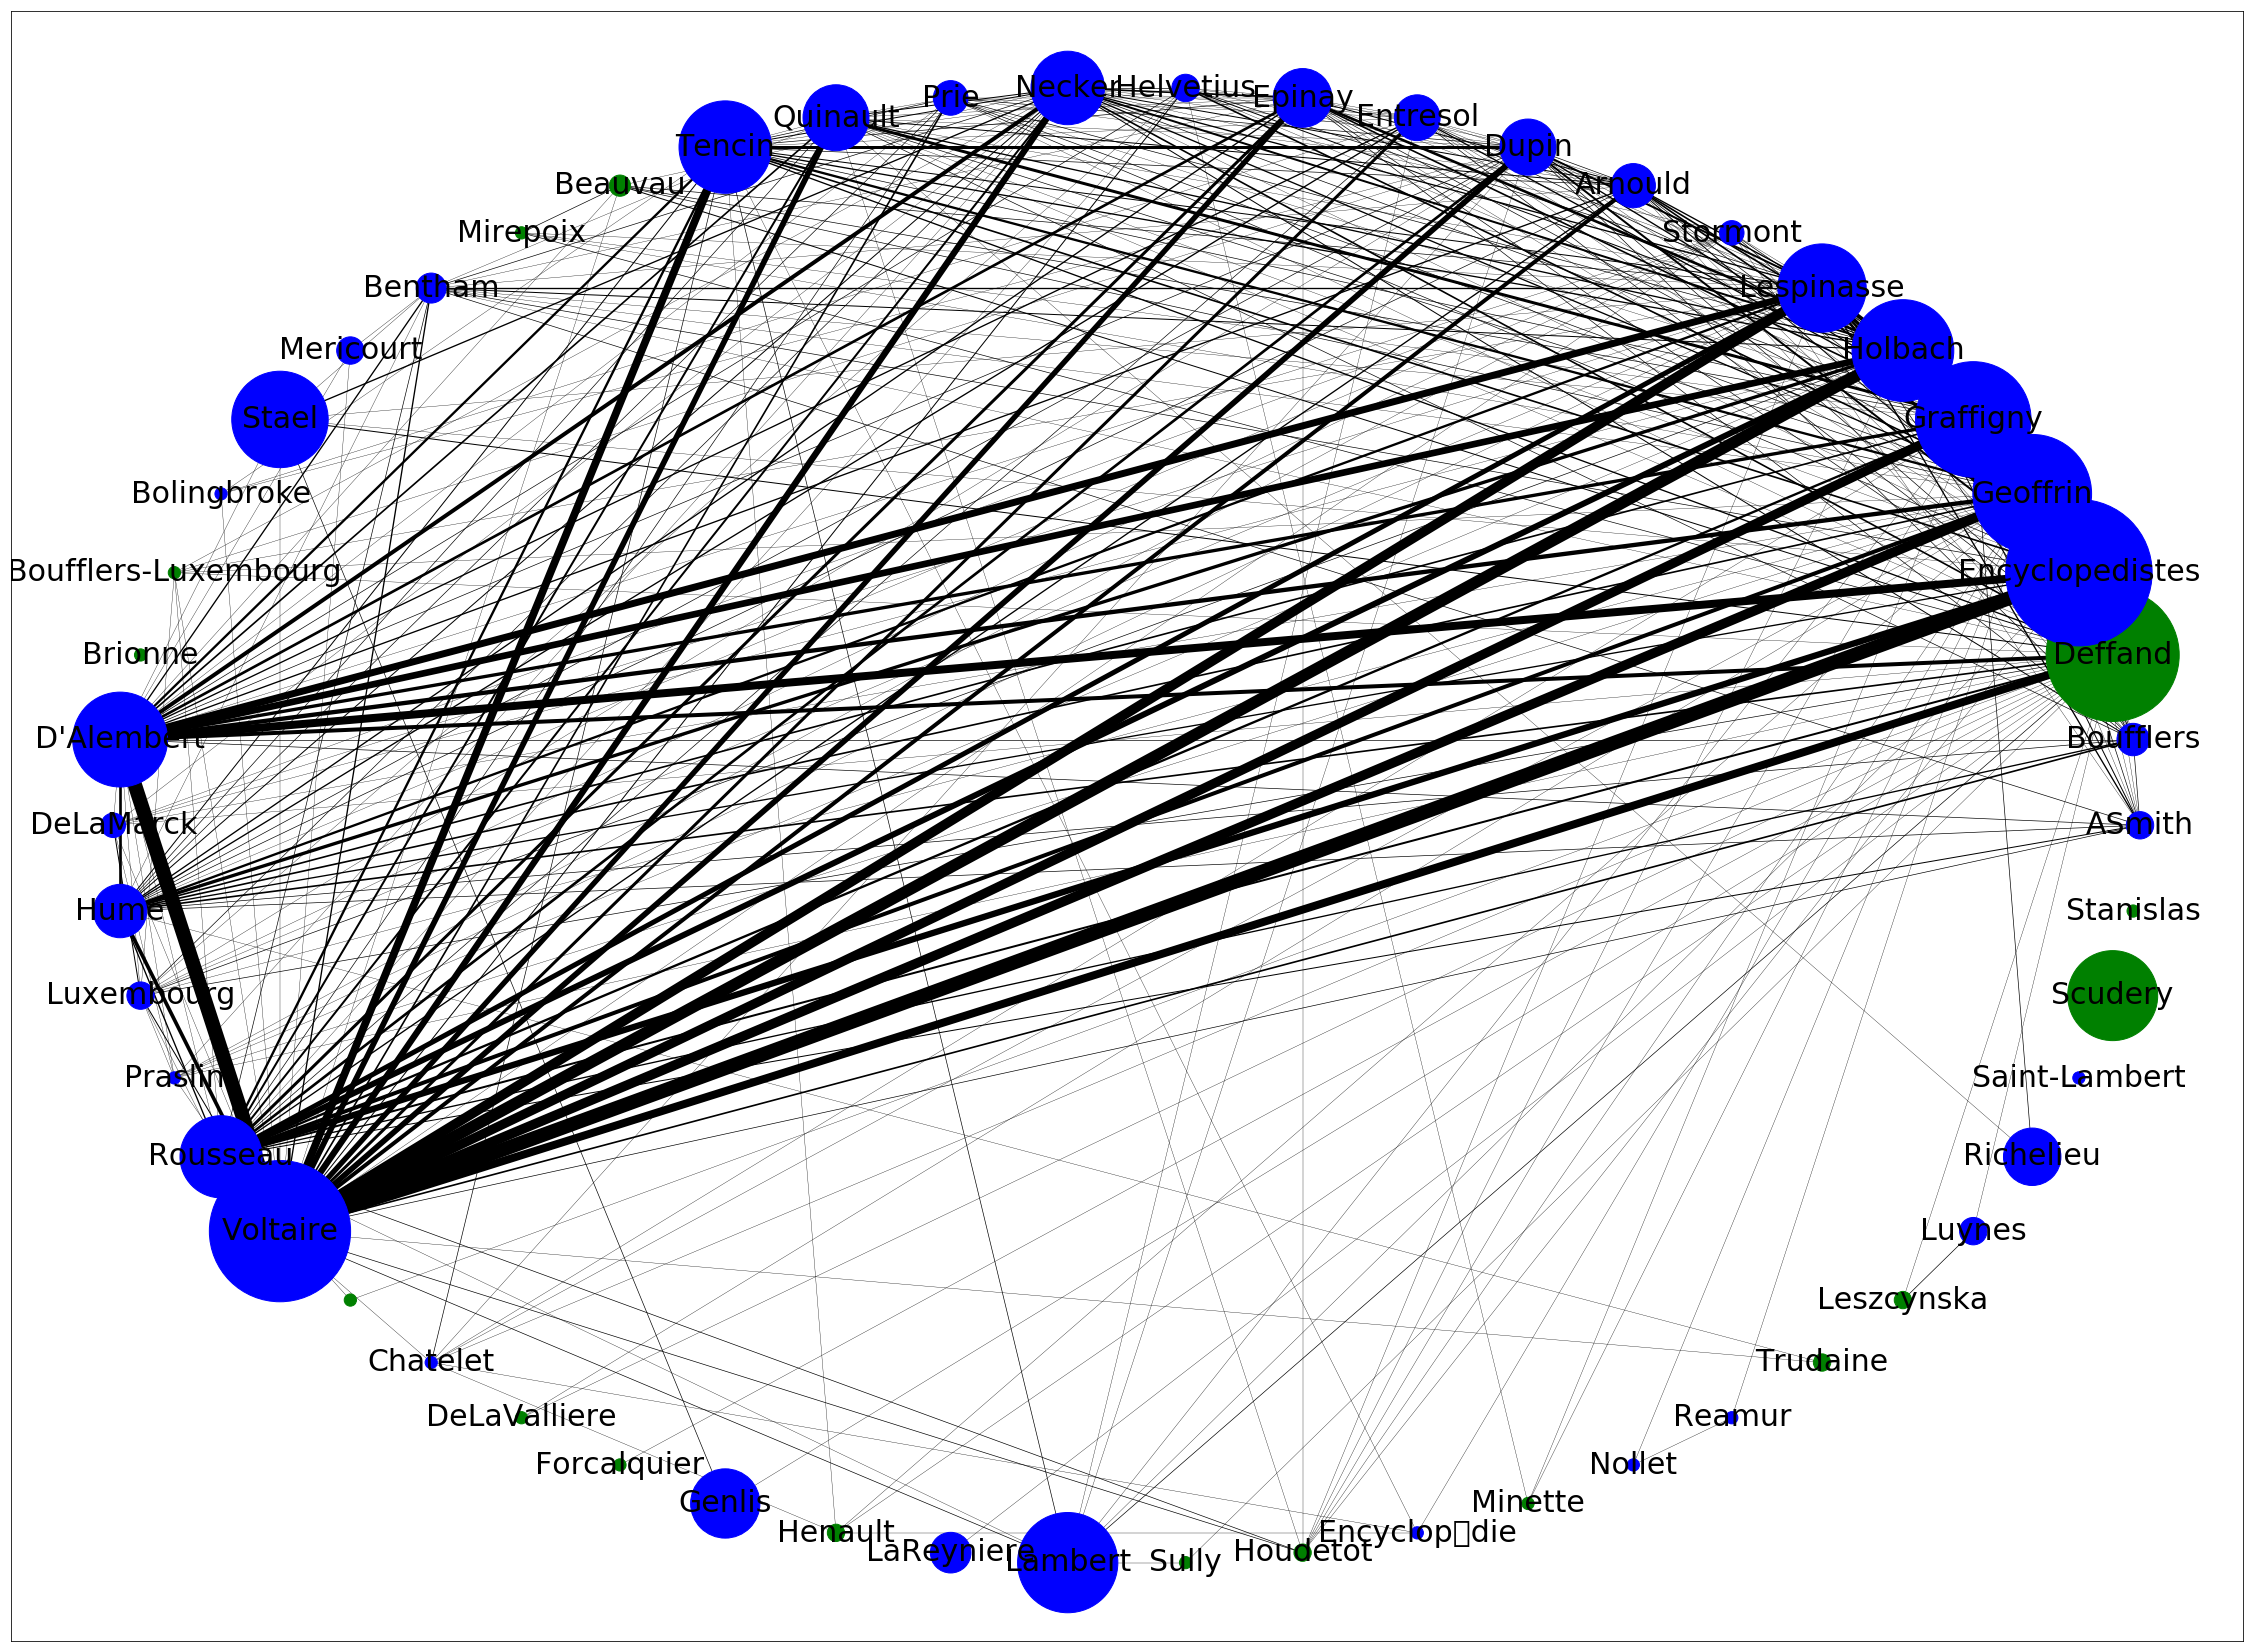

In [5]:
# extract edges from dataframe
G = nx.from_pandas_edgelist(
    df=df_edgelist,
    source="Source",
    target="Target",
    edge_attr=["Pair Counts","Ego Network Count"],
)

# edge weights
edge_weight = [i['Pair Counts'] for i in dict(G.edges).values()]
edge_weight = np.array(edge_weight) / 3
# edge_weight = np.log1p(edge_weight)
# edge_weight = np.log(edge_weight)

# determine colors for Gender
color_map = []
for ego, gender in zip(df_attribute["EgoNetworksCombined"], df_attribute["Majority Attribute"]):
    if gender == "Male":
        color_map.append('blue')
    else: 
        color_map.append('green')

# color map        
color_map = {}
for i in G.nodes():
    try:
        gender = np.unique(df_attribute[df_attribute["EgoNetworksCombined"] == i]["Majority Attribute"])[0]
        if gender == "Male":
            color_map[i] = "blue"
        else:
            color_map[i] = "green"
    except:
        color_map[i] = "Male"
color_map = list(color_map.values())        

# node size
node_size = {}
for i in G.nodes():
    try:
        node_size[i] = np.unique(df_edgelist[df_edgelist["Source"] == i]["Ego Network Count"])[0] * 150
    except:
        node_size[i] = 1 * 150
node_size = list(node_size.values())

# labels
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

# make network
fig, ax = plt.subplots(figsize=(40,30))
pos = nx.circular_layout(G, scale=5)

nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    node_size=node_size,
    node_color=color_map
)
nx.draw_networkx_edges(G, pos, width=edge_weight, ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=30)

# Network demo

In [ ]:
df_combo = df_salons.merge(df_social_network, left_index=True, right_index=True, how="outer")
df_combo = df_combo.groupby(['Salons','Social Network']).size().reset_index()
df_combo = df_combo.rename({0: "Counts"}, axis=1)

In [ ]:
G = nx.from_pandas_edgelist(
#     df=df_combo[df_combo["Social Network"] == "Government"],
    df=df_combo[df_combo["Salons"] == "Deffand"],
#     df=df_combo,
    source="Salons",
    target="Social Network",
    edge_attr="Counts"
)
durations = [i['Counts'] for i in dict(G.edges).values()]
durations = np.log1p(durations)
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(20,10))
pos = nx.spring_layout(G, scale=1)
nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,
    node_size=df_combo["Counts"].values * 1000
)
nx.draw_networkx_edges(G, pos, width=durations, ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=20)

# Review DataFrames & Basic Visualizations

In [ ]:
def category_prob_barh(df, column, other_threshold=0.02):
    # set figure size and facecolor
    plt.rcParams["figure.figsize"] = (20,12)
    plt.rcParams['axes.facecolor'] = 'ffffff'
    plt.rcParams["figure.facecolor"] = 'ffffff'
    
    prob = df[column].value_counts(normalize=True)
    threshold = other_threshold
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['other'] = tail_prob
    prob[::-1].plot(kind='barh')
    plt.xticks(rotation=0, size=20)
    plt.yticks(size=20)

    plt.show()
    
def category_count_barh(df, column, top_n):
    df[column].value_counts()[:top_n].plot(kind='barh', fontsize=20).invert_yaxis()

## Main

In [ ]:
df_main.info()
display(df_main.head(10))

## Academies

In [ ]:
df_academies.info()
display(df_academies.head(10))

In [ ]:
category_prob_barh(df=df_academies, column="Academies")

In [ ]:
category_count_barh(df=df_academies, column="Academies", top_n=10)

## Aristocracy title

In [ ]:
df_aristo_title.info()
display(df_aristo_title.head(10))

In [ ]:
category_prob_barh(df=df_aristo_title, column="Aristo title")

In [ ]:
category_count_barh(df=df_aristo_title, column="Aristo title", top_n=10)

## Ego networks combined

In [ ]:
df_egonetworkscombined.info()
display(df_egonetworkscombined.head(10))

In [ ]:
category_prob_barh(df=df_egonetworkscombined, column="EgoNetworksCombined")

In [ ]:
category_count_barh(df=df_egonetworkscombined, column="EgoNetworksCombined", top_n=10)

## Knowledge network

In [ ]:
df_knowledge_network.info()
display(df_knowledge_network.head(10))

In [ ]:
category_prob_barh(df=df_knowledge_network, column="Knowledge Network")

In [ ]:
category_count_barh(df=df_knowledge_network, column="Knowledge Network", top_n=10)

## Military rank

In [ ]:
df_military_rank.info()
display(df_military_rank.head(10))

In [ ]:
category_prob_barh(df=df_military_rank, column="Military rank")

In [ ]:
category_count_barh(df=df_military_rank, column="Military rank", top_n=10)

## Nationality

In [ ]:
df_nationality.info()
display(df_nationality.head(10))

In [ ]:
category_prob_barh(df=df_nationality, column="Nationality")

In [ ]:
category_count_barh(df=df_nationality, column="Nationality", top_n=10)

## Occupation

In [ ]:
df_occupation.info()
display(df_occupation.head(10))

In [ ]:
category_prob_barh(df=df_occupation, column="Occupation")

In [ ]:
category_count_barh(df=df_occupation, column="Occupation", top_n=10)

## Political rank

In [ ]:
df_political_rank.info()
display(df_political_rank.head(10))

In [ ]:
category_prob_barh(df=df_political_rank, column="Political rank")

In [ ]:
category_count_barh(df=df_political_rank, column="Political rank", top_n=10)

## Professional network

In [ ]:
df_professional_network.info()
display(df_professional_network.head(10))

In [ ]:
category_prob_barh(df=df_professional_network, column="Professional Network")

In [ ]:
category_count_barh(df=df_professional_network, column="Professional Network", top_n=10)

## Salons

In [ ]:
df_salons.info()
display(df_salons.head(10))

In [ ]:
category_prob_barh(df=df_salons, column="Salons")

In [ ]:
category_count_barh(df=df_salons, column="Salons", top_n=10)

## Social network

In [ ]:
df_social_network.info()
display(df_social_network.head(10))

In [ ]:
category_prob_barh(df=df_social_network, column="Social Network")

In [ ]:
category_count_barh(df=df_social_network, column="Social Network", top_n=10)

## Source

In [ ]:
df_source.info()
display(df_source.head(10))

In [ ]:
category_prob_barh(df=df_source, column="Source")

In [ ]:
category_count_barh(df=df_source, column="Source", top_n=10)